# 4.1A PopNet optimization

This tutorial demonstrates a method for optimizing Stabilized Supralinear Network (SSN) model parameters using an optimizer.

This example requires the 'numba' and 'iminuit' packages. Please ensure they are installed to run the notebook. While Numba is not strictly required for running the SSN model, its inclusion accelerates the simulation by approximately 50-100 times, making it more practical for optimization tasks.

Reference: [Coordinated changes in a cortical circuit sculpt effects of novelty on neural dynamics](https://www.sciencedirect.com/science/article/pii/S2211124724011148)


In [1]:
%%html
<style>table {float:left;display:block}</style>




In [2]:
# Import block
from bmtk.simulator import popnet
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
import pickle
import numpy as np
from iminuit import minimize


# For visualization
line_cols = {  # copied form project_colors in util
    "Sst-IRES-Cre": (158 / 255, 218 / 255, 229 / 255),
    "sst": (158 / 255, 218 / 255, 229 / 255),
    "Slc17a7-IRES2-Cre": (255 / 255, 152 / 255, 150 / 255),
    "slc": (255 / 255, 152 / 255, 150 / 255),
    "Vip-IRES-Cre": (197 / 255, 176 / 255, 213 / 255),
    "vip": (197 / 255, 176 / 255, 213 / 255),
}
color_list = [line_cols["slc"], "mediumaquamarine", line_cols["sst"], line_cols["vip"]]
mpl.rcParams["axes.prop_cycle"] = cycler(color=color_list)

## Optimizing network parameters

In this example, the SSN PopNet is used in an interactive mode and used for parameter optimization. First, load the network and instantiate the simulator.

In [3]:
@popnet.inputs_generator
def load_bkg_inputs(node, sim, **opts):
    # print(node.node_id, node.population)
    # print(sim.dt, sim.tstart, sim.tstop, sim.nsteps)
    return np.ones(sim.nsteps)


configure = popnet.Config.from_json('config.simulation.json')
configure.build_env()

network = popnet.PopNetwork.from_config(configure)
sim = popnet.PopSimulator.from_config(configure, network)

2025-05-22 16:19:08,048 [INFO] Created log file
2025-05-22 16:19:08,065 [INFO] Building nodes.
2025-05-22 16:19:08,066 [INFO] Building connections.
2025-05-22 16:19:08,067 [INFO] Add input module "init_states"
2025-05-22 16:19:08,068 [INFO] Add input module "l4_inputs"
2025-05-22 16:19:08,070 [INFO] Add input module "bkg_inputs"


When the simulator is run with 'return_output' option, the results are returned a variable instead of being written to a file.
This mechanism facilitates the formulation of an optimization problem.

In [4]:
results = sim.run(return_output=True)

print(results.shape)

(13500, 6)


The result will have a shape of (time steps, number of nodes) including the external units.
To retrieve the activity of only the recurrent units, one can do:

[[1.38853652 3.50304166 1.61686557 5.02447877]
 [1.38884923 3.50402647 1.6179342  5.02851101]
 [1.38883864 3.50404038 1.61873297 5.03235881]
 ...
 [1.38709075 3.49855563 1.61244919 5.01181986]
 [1.38767691 3.50036444 1.61408329 5.01612201]
 [1.38833074 3.50237521 1.61559399 5.02040123]]


Text(0.5, 1.0, 'Simulated traces')

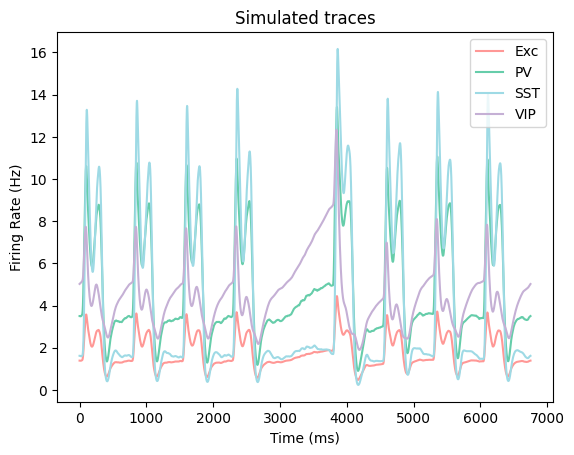

In [5]:
print(results[:, :network.n_neu_recurrent])


# %% simulation runs the network twice, first half for stabilizing the activity, second half for recording the activity
duration = 6750

def plot_traces(results):
    plt.plot(results)
    plt.legend(["Exc", "PV", "SST", "VIP"])
    plt.xlabel("Time (ms)")
    plt.ylabel("Firing Rate (Hz)")
    
# plot only the second half of the simulation
plot_traces(results[duration:duration*2, :network.n_neu_recurrent])
plt.title("Simulated traces")

Now let's load some target data. The present model is pre-optimized to reproduce this data.

Text(0.5, 1.0, 'Experimental traces')

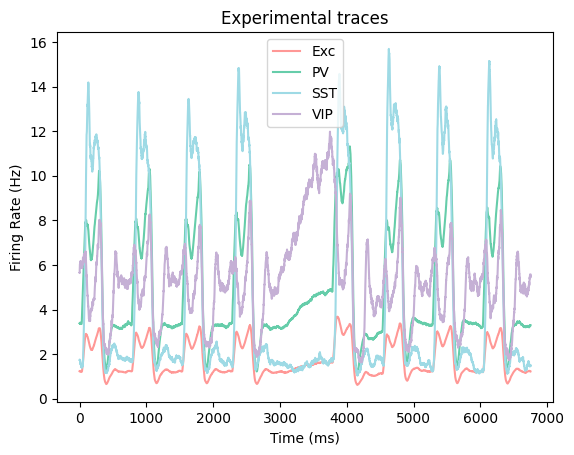

In [6]:
with open('optim_data/l23_mean_traces.pkl', 'rb') as f:
    l23_mean_traces = pickle.load(f)

l23_mean_traces.keys()

cells_to_read = ['RS_G', 'FS_G', 'SST_G', 'VIP_G']
mean_traces = np.array([l23_mean_traces[cell]["mean"] for cell in cells_to_read]).T

plot_traces(mean_traces[:duration])
plt.title("Experimental traces")



For a demonstration purpose, let's jitter the parameters of the model.

In [7]:
# Jitter parameters by 5%.

original_connectivity_mat = network.connectivity_mat
original_decay_constants = network.decay_constants

Text(0.5, 1.0, 'Jittered traces')

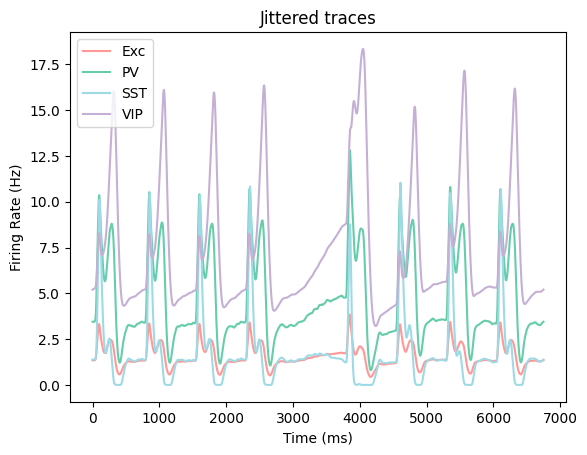

In [8]:
# fix the seed for reproducibility
np.random.seed(0)

frac_change = 0.01

new_connectivity_mat = original_connectivity_mat * np.random.uniform(1-frac_change, 1+frac_change, original_connectivity_mat.shape)
new_decay_constants = original_decay_constants * np.random.uniform(1-frac_change, 1+frac_change, original_decay_constants.shape)

# set the new parameters to the network
network.connectivity_mat = new_connectivity_mat
network.decay_constants = new_decay_constants

# run simulation
results_jittered = sim.run(return_output=True)


# plot the results
plot_traces(results_jittered[duration:duration*2, :network.n_neu_recurrent])
plt.title("Jittered traces")


We can see that the jittered traces have different SST/VIP balances. Let's see whether we can recover the activity of the original model through optimization. First let's define the loss function simply as the mean square errors between the model and target traces.

In [9]:
def loss_function(results, target):
    # pick up the time window that corresponds to the target data
    # For the simulation, the first half is for stabilizing the activity.
    # The second half should be compared with the target data.
    results = results[duration:duration*2]
    target = target[:duration]
    
    return np.mean((results - target)**2)

def set_parameters(parameters):
    matrix_parameters = parameters[:network.connectivity_mat.size]
    decay_parameters = parameters[network.connectivity_mat.size:]

    network.connectivity_mat = matrix_parameters.reshape(network.connectivity_mat.shape)
    network.decay_constants = decay_parameters
    return

# formulate the optimization problem
def optim_func(parameters):
    set_parameters(parameters)

    results = sim.run(return_output=True)
    
    loss = loss_function(results[:, :network.n_neu_recurrent], mean_traces)
    return loss


# let's minimize using minimize in iminuit
init_parameters = np.concatenate([network.connectivity_mat.flatten(), network.decay_constants])
m = minimize(optim_func, init_parameters)

print(m.message)
print(m.x)

Optimization terminated successfully.
[ 3.26582520e-02 -9.51552194e-03 -1.20423184e-03 -3.06067351e-04
  1.25451260e-02  8.71665535e-03  4.03836696e-02 -1.24359888e-02
 -2.73894555e-03 -7.28094768e-04  2.80587844e-02  1.39064582e-04
  7.55342953e-02 -4.55712809e-03 -1.81240800e-04 -7.35804537e-03
  3.93736453e-03  2.83286709e-03  5.52239624e-02  2.68534950e-04
 -1.26825971e-02 -1.32681187e-04  1.21353784e-02  1.94150006e-02
  1.00500429e+01  1.18257399e+01  1.00159482e+01  4.93117046e+01]


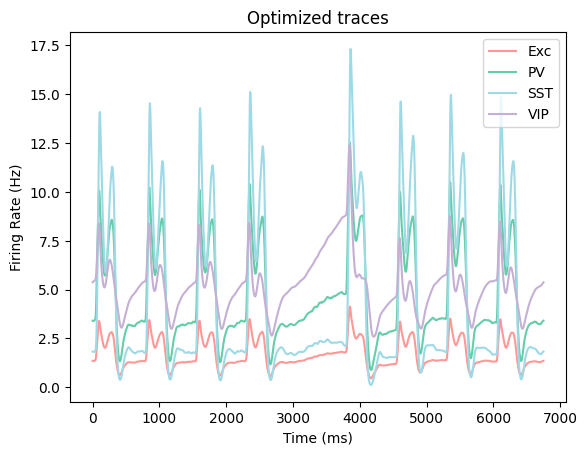

In [10]:
# Plot the results of the optimized network.
set_parameters(m.x)

results = sim.run(return_output=True)

plot_traces(results[duration:duration*2, :network.n_neu_recurrent])
plt.title("Optimized traces")
plt.show()

We successfully recovered the original activity of the network that matches with the experiment. Note that this is a simple demonstration of the optimization using the SSN model. Real-world optimization problem using the SSN model is typically much more difficult and require more elaborated setup. Please refer to the paper [Coordinated changes in a cortical circuit sculpt effects of novelty on neural dynamics](https://www.sciencedirect.com/science/article/pii/S2211124724011148) for an example of an actual study.

[**Proceed to Chapter 5**](../Ch5_filternet/5.%20FilterNet.ipynb)